In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [104]:
train_data = pd.read_csv("BG2024_train.csv")
test_data = pd.read_csv("BG2024_test.csv")


In [105]:
train_data

,RowID,WID,Date,Year,Month,StoreID,Open,PrdID,FamID,Fam,PrdLife,Price,Qty
0,1,1,2020-11-02,2020,11,100,7,142,1,ABITO,0,139.0,1
1,2,1,2020-11-02,2020,11,100,7,158,8,CAPPELLO,0,19.9,3
2,3,1,2020-11-02,2020,11,100,7,159,8,CAPPELLO,0,10.0,1
3,4,1,2020-11-02,2020,11,100,7,161,8,CAPPELLO,0,10.0,4
4,5,1,2020-11-02,2020,11,100,7,282,20,GIUBBOTTO/GIACCONE,0,119.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177762,177763,55,2021-11-15,2021,11,545,2,447,1,ABITO,54,129.9,1
177763,177764,55,2021-11-15,2021,11,546,3,349,23,MAGLIERIA BASICA,54,29.9,1
177764,177765,55,2021-11-15,2021,11,546,3,447,1,ABITO,54,129.9,1
177765,177766,55,2021-11-15,2021,11,547,4,147,2,ACCESSORI VARI,9,29.9,1


In [4]:
test_data

,RowID,WID,Date,Year,Month,StoreID,Open,PrdID,FamID,Fam,PrdLife,Price
0,177768,56,2021-11-22,2021,11,100,7,1,6,CAMICIA CLASSICA,55,19.9
1,177769,56,2021-11-22,2021,11,100,7,2,12,CRAVATTA,50,15.0
2,177770,56,2021-11-22,2021,11,100,7,3,12,CRAVATTA,53,15.0
3,177771,56,2021-11-22,2021,11,100,7,4,31,SCARPE,49,59.9
4,177772,56,2021-11-22,2021,11,100,7,5,12,CRAVATTA,53,19.9
...,...,...,...,...,...,...,...,...,...,...,...,...
348313,526081,61,2021-12-27,2021,12,547,4,519,12,CRAVATTA,39,15.0
348314,526082,61,2021-12-27,2021,12,547,4,520,12,CRAVATTA,39,10.0
348315,526083,61,2021-12-27,2021,12,547,4,521,12,CRAVATTA,57,10.0
348316,526084,61,2021-12-27,2021,12,547,4,522,12,CRAVATTA,42,10.0


In [106]:
tr_X = train_data.iloc[:, :-1]
tr_Y = train_data.iloc[:, -1]
forecast_X = test_data

Missing values:
 RowID      0
WID        0
Date       0
Year       0
Month      0
StoreID    0
Open       0
PrdID      0
FamID      0
Fam        0
PrdLife    0
Price      0
Qty        0
dtype: int64


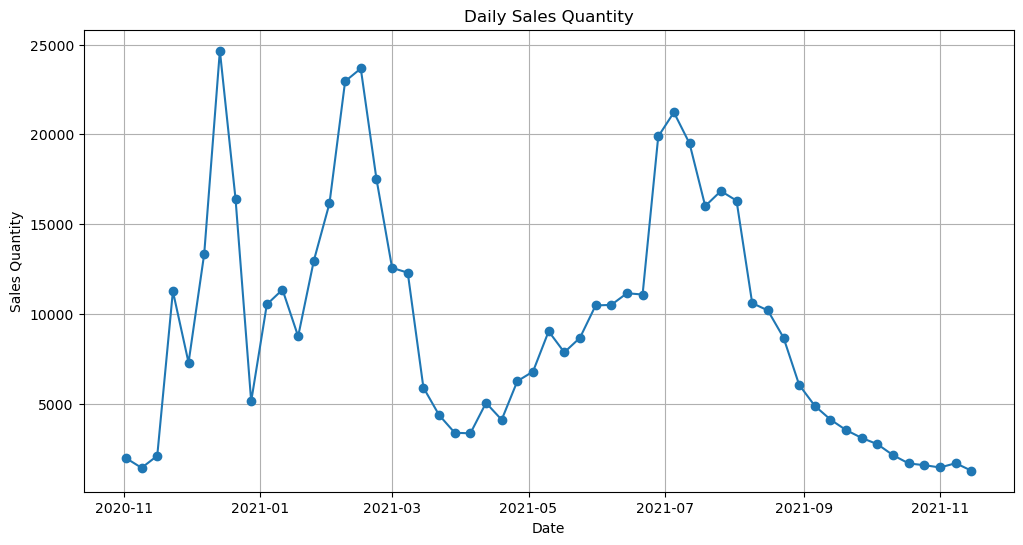

In [84]:
# Convert 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing values:\n", missing_values)

# Optionally, aggregate the train_data to the desired level of granularity (e.g., daily, weekly)
# For example, aggregate sales quantities by day
daily_sales = train_data.groupby('Date')['Qty'].sum().reset_index()

# Visualize the time series train_data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Qty'], marker='o', linestyle='-')
plt.title('Daily Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.grid(True)
plt.show()


In [10]:
missing_values = test_data.isnull().sum()
print("Missing values:\n", missing_values)


Missing values:
 RowID      0
WID        0
Date       0
Year       0
Month      0
StoreID    0
Open       0
PrdID      0
FamID      0
Fam        0
PrdLife    0
Price      0
dtype: int64


Stationarity is an important concept in time series analysis. A stationary time series is one whose statistical properties such as mean, variance, and autocorrelation structure do not change over time. In order to apply ARIMA models effectively, it's often necessary to ensure that the data is stationary.

We can perform a stationarity check using the Augmented Dickey-Fuller (ADF) test, which is a statistical test commonly used to determine whether a unit root is present in a time series dataset. A unit root would indicate non-stationarity.



In [87]:
tr_X = train_data.iloc[:, :-1]
tr_Y = train_data.iloc[:, -1]
forecast_X = test_data

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Drop datetime columns (assuming 'Date' is a datetime column)
tr_X_numeric = tr_X.drop(columns=['Date'])
forecast_X_numeric = forecast_X.drop(columns=['Date'])

# One-hot encode categorical variables (if applicable)
tr_X_encoded = pd.get_dummies(tr_X_numeric)
forecast_X_encoded = pd.get_dummies(forecast_X_numeric)

# Initialize and train the random forest regression model
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(tr_X_encoded, tr_Y)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [47]:
tr_Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 177767 entries, 0 to 177766
Series name: Qty
Non-Null Count   Dtype
--------------   -----
177767 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [46]:
tr_X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177767 entries, 0 to 177766
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RowID                       177767 non-null  int64  
 1   WID                         177767 non-null  int64  
 2   Year                        177767 non-null  int64  
 3   Month                       177767 non-null  int64  
 4   StoreID                     177767 non-null  int64  
 5   Open                        177767 non-null  int64  
 6   PrdID                       177767 non-null  int64  
 7   FamID                       177767 non-null  int64  
 8   PrdLife                     177767 non-null  int64  
 9   Price                       177767 non-null  float64
 10  Fam_ABITO                   177767 non-null  bool   
 11  Fam_ACCESSORI VARI          177767 non-null  bool   
 12  Fam_BORSA                   177767 non-null  bool   
 13  Fam_BRETELLE  

In [48]:
tr_X_encoded = tr_X_encoded.astype(int)

In [58]:
tr_X_encoded[5:10]

,RowID,WID,Year,Month,StoreID,Open,PrdID,FamID,PrdLife,Price,...,Fam_MAGLIERIA FASHION,Fam_PANTALONE BERMUDA,Fam_PANTALONI,Fam_PANTALONI ABITO BASICO,Fam_PAPILLON,Fam_PIGIAMA,Fam_POCHETTE,Fam_SCARPE,Fam_SCIARPA E PASHMINA,Fam_T-SHIRT
5,6,1,2020,11,100,7,286,20,0,129,...,0,0,0,0,0,0,0,0,0,0
6,7,1,2020,11,100,7,390,26,0,49,...,0,0,1,0,0,0,0,0,0,0
7,8,1,2020,11,100,7,392,26,0,49,...,0,0,1,0,0,0,0,0,0,0
8,9,1,2020,11,100,7,394,26,0,49,...,0,0,1,0,0,0,0,0,0,0
9,10,1,2020,11,100,7,422,32,0,24,...,0,0,0,0,0,0,0,0,1,0


In [107]:
tr_X['Date'] = pd.to_datetime(tr_X['Date'])

# Extract day from 'Date' column
tr_X['Day'] = tr_X['Date'].dt.day

# Drop the original 'Date' column if no longer needed
tr_X.drop(columns=['Date'], inplace=True)

forecast_X['Date'] = pd.to_datetime(forecast_X['Date'])
forecast_X['Day'] = forecast_X['Date'].dt.day
forecast_X.drop(columns=['Date'], inplace=True)

In [110]:
tr_X_encoded = pd.get_dummies(tr_X_numeric)
forecast_X_encoded = pd.get_dummies(forecast_X_numeric)


In [112]:
tr_X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177767 entries, 0 to 177766
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RowID                       177767 non-null  int64  
 1   WID                         177767 non-null  int64  
 2   Year                        177767 non-null  int64  
 3   Month                       177767 non-null  int64  
 4   StoreID                     177767 non-null  int64  
 5   Open                        177767 non-null  int64  
 6   PrdID                       177767 non-null  int64  
 7   FamID                       177767 non-null  int64  
 8   PrdLife                     177767 non-null  int64  
 9   Price                       177767 non-null  float64
 10  Fam_ABITO                   177767 non-null  bool   
 11  Fam_ACCESSORI VARI          177767 non-null  bool   
 12  Fam_BORSA                   177767 non-null  bool   
 13  Fam_BRETELLE  

In [113]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(tr_X_encoded, tr_Y)


RandomForestRegressor(random_state=42)

In [114]:
y_pred = model.predict(forecast_X_encoded)
y_pred_int = y_pred.round().astype(int)

In [115]:
with open("predictions_bg24_other.txt", "w") as file:
    for prediction in y_pred_int:
        file.write(str(prediction) + "\n")

In [116]:
model = SVC(kernel='rbf', random_state=42) 
model.fit(tr_X_encoded, tr_Y)



In [90]:
tr_X['Date'] = pd.to_datetime(tr_X['Date'])
forecast_X['Date'] = pd.to_datetime(forecast_X['Date'])

# Set 'Date' column as the index
tr_X.set_index('Date', inplace=True)
forecast_X.set_index('Date', inplace=True)

In [101]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def root_mean_squared_error(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true_float)))


model = Sequential([
    LSTM(units=128, input_shape=(tr_X_encoded.shape[1], 1), return_sequences=True),
    LSTM(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss=root_mean_squared_error)


In [102]:
import numpy as np

# Reshape input data for LSTM
X_train = np.reshape(tr_X_encoded.values, (tr_X_encoded.shape[0], tr_X_encoded.shape[1], 1))


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, tr_Y, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])


In [ ]:
# Assuming you have validation data prepared in a similar way as training data
# Reshape validation data
X_val = np.reshape(val_X_encoded.values, (val_X_encoded.shape[0], val_X_encoded.shape[1], 1))

# Evaluate the model
mse = model.evaluate(X_val, val_Y)


In [79]:
# def root_mean_squared_error(y_true, y_pred):
#     # Convert y_pred to int64 to match the data type of y_true
#     y_pred_int = np.array(y_pred, dtype=np.int64)
#     return np.sqrt(np.mean(np.square(y_pred_int - y_true)))

# def root_mean_squared_error(y_true, y_pred):
#     # Convert y_pred to int64 to match the data type of y_true
#     y_pred_int = tf.cast(y_pred, tf.int64)
#     y_true_int = tf.cast(y_true, tf.int64)
    
#     squared_diff = tf.square(tf.cast(y_pred_int - y_true_int, tf.float32))
#     mean_squared_error = tf.reduce_mean(squared_diff)
#     return tf.sqrt(mean_squared_error)

# def root_mean_squared_error(y_true, y_pred):
#     # Define the NumPy function for RMSE calculation
#     def numpy_rmse(y_true_np, y_pred_np):
#         y_pred_int = np.array(y_pred_np, dtype=np.int64)
#         return np.sqrt(np.mean(np.square(y_pred_int - y_true_np)))

#     # Wrap the NumPy function with tf.numpy_function
#     rmse = tf.numpy_function(numpy_rmse, [y_true, y_pred], tf.float64)
#     return rmse

def root_mean_squared_error(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true_float)))

model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(tr_X_encoded.shape[1],)),
    # keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1)  # Output layer with one neuron for regression
])


model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =[root_mean_squared_error])

In [66]:
tr_X_encoded.shape

(177767, 43)

In [67]:
tr_Y

0         1
1         3
2         1
3         4
4         1
         ..
177762    1
177763    1
177764    1
177765    1
177766    1
Name: Qty, Length: 177767, dtype: int64

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(tr_X_encoded, tr_Y, epochs=100, validation_split=0.2, verbose=2, callbacks=[early_stopping])


Epoch 1/100
4445/4445 - 5s - loss: 4.3022 - root_mean_squared_error: 4.3017 - val_loss: 3.3600 - val_root_mean_squared_error: 3.3581 - 5s/epoch - 1ms/step
Epoch 2/100
4445/4445 - 4s - loss: 4.3010 - root_mean_squared_error: 4.3010 - val_loss: 3.0083 - val_root_mean_squared_error: 3.0067 - 4s/epoch - 998us/step
Epoch 3/100
4445/4445 - 5s - loss: 4.2977 - root_mean_squared_error: 4.3001 - val_loss: 5.6509 - val_root_mean_squared_error: 5.6488 - 5s/epoch - 1ms/step
Epoch 4/100
4445/4445 - 5s - loss: 4.2873 - root_mean_squared_error: 4.2868 - val_loss: 3.0763 - val_root_mean_squared_error: 3.0747 - 5s/epoch - 1ms/step
Epoch 5/100
4445/4445 - 4s - loss: 4.2813 - root_mean_squared_error: 4.2817 - val_loss: 6.3524 - val_root_mean_squared_error: 6.3501 - 4s/epoch - 998us/step
Epoch 6/100
4445/4445 - 4s - loss: 4.2839 - root_mean_squared_error: 4.2833 - val_loss: 3.2058 - val_root_mean_squared_error: 3.2041 - 4s/epoch - 1ms/step
Epoch 7/100
4445/4445 - 4s - loss: 4.2741 - root_mean_squared_erro

In [11]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(daily_sales['Qty'])

# Print test statistics
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: -2.7836599100141495
p-value: 0.060646007733482
Critical Values:
	1%: -3.5925042342183704
	5%: -2.931549768951162
	10%: -2.60406594375338


Two methods are worth to try, first forecasting model and second removing the dates and consider it as regression model as the dates are not so diverse.

In [12]:
# Apply differencing to the sales quantity
daily_sales_diff = daily_sales['Qty'].diff().dropna()  # Drop NA values resulting from differencing

# Perform Augmented Dickey-Fuller test on differenced data
result_diff = adfuller(daily_sales_diff)

# Print test statistics for differenced data
print('ADF Statistic (after differencing):', result_diff[0])
print('p-value (after differencing):', result_diff[1])
print('Critical Values (after differencing):')
for key, value in result_diff[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic (after differencing): -2.287479582091819
p-value (after differencing): 0.17603785735766336
Critical Values (after differencing):
	1%: -3.5885733964124715
	5%: -2.929885661157025
	10%: -2.6031845661157025


                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                   55
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -529.603
Date:                Thu, 11 Apr 2024   AIC                           1067.206
Time:                        10:03:16   BIC                           1075.235
Sample:                             0   HQIC                          1070.311
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9344.2181   2015.854      4.635      0.000    5393.217    1.33e+04
ar.L1          0.6486      0.119      5.437      0.000       0.415       0.882
ma.L1          0.4694      0.097      4.820      0.0

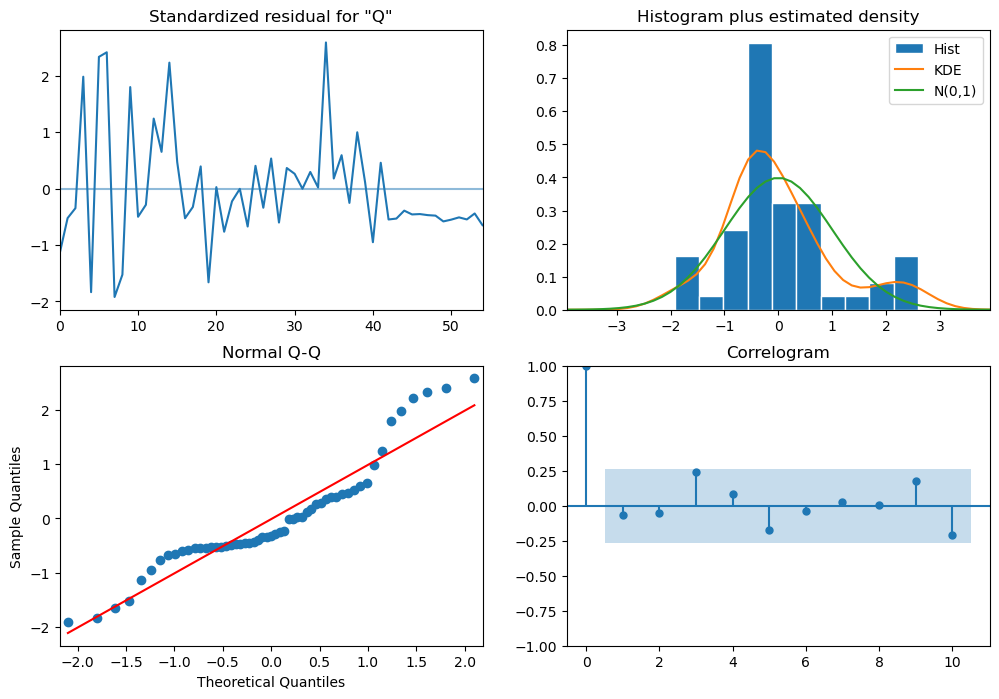

In [24]:

# Identify orders (p, d, q)
# Example: p=1, d=0, q=1
p, d, q = 1, 0, 1

# Fit ARIMA model
model = ARIMA(daily_sales['Qty'], order=(p, d, q))
result = model.fit()

# Print model summary
print(result.summary())

# Plot residuals
result.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast
# forecast_steps = 30  # Number of steps to forecast
# forecast = result.forecast(steps=forecast_steps)

# # Print forecast
# print("Forecasted values for the next {} steps:".format(forecast_steps))
# print(forecast)


In [18]:

# Actual values
actual_values = daily_sales['Qty'][-forecast_steps:]

# Forecasted values
forecast_values = forecast

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 5995.194738348556


In [25]:
# Assuming test dataset is loaded and preprocessed, and model is already fitted

# Generate forecasts for test dataset
forecast_test = result.forecast(steps=len(test_data))

# Extract actual values from test dataset
# actual_values_test = test_data['Qty']

# Calculate RMSE for test dataset
# rmse_test = np.sqrt(mean_squared_error(test_data, forecast_test))
# print("Root Mean Squared Error (RMSE) for Test Data:", rmse_test)


In [26]:
forecast_test

55        3004.193924
56        5231.975357
57        6676.950608
58        7614.185044
59        8222.090535
             ...     
348368    9344.218093
348369    9344.218093
348370    9344.218093
348371    9344.218093
348372    9344.218093
Name: predicted_mean, Length: 348318, dtype: float64

In [ ]:

# Fit ARIMA model with training data
model = ARIMA(train_data['Qty'], order=(p, d, q))
result = model.fit()

# Forecast sales quantities for test data
forecast_test = result.forecast(steps=len(test_data))

# Print forecasted quantities for the test dataset
print("Forecasted quantities for the test dataset:")
print(forecast_test)
